In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/Road/FRCNN Google colab/FRCNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/Road/FRCNN Google colab/FRCNN


In [ ]:
import random
import pprint
import time
import numpy as np
import pickle
import pandas as pd
import math
import gc
import sys
import os
import cv2

from keras import backend as K
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
from keras.utils import generic_utils
from keras.callbacks import TensorBoard
import tensorflow as tf

import keras_frcnn.roi_helpers as roi_helpers
from keras_frcnn import data_generators
from keras_frcnn.simple_parser import get_data
from keras_frcnn import losses as Losses
from keras_frcnn import config
from keras_frcnn import nn_arch_vgg16 as nn

In [ ]:
def format_img_size(img, C): # utility function 1
    """ formats the image size based on config """
    img_min_side = float(C.im_size)
    (height,width,_) = img.shape

    if width <= height:
        ratio = img_min_side/width
        new_height = int(ratio * height)
        new_width = int(img_min_side)
    else:
        ratio = img_min_side/height
        new_width = int(ratio * width)
        new_height = int(img_min_side)
    fx = width/float(new_width)
    fy = height/float(new_height)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    return img, ratio,(fx,fy)

def preprocess_img(img, preprocessing_function): #utility function 2
    """ formats the image channels based on config """
    img = img[:, :, (2, 1, 0)] #bgr to rgb
    if preprocessing_function:
        img = preprocessing_function(img)
    #img = np.transpose(img, (2, 0, 1)) # convert to theano
    img = np.expand_dims(img, axis=0)
    return img

def format_img(img, C, preprocessing_function): # utility function 3
    """ formats an image for model prediction based on config """
    img, ratio, fxfy = format_img_size(img, C)
    img = preprocess_img(img, preprocessing_function)
    return img, ratio, fxfy

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2): #utility function 4

    real_x1 = int(round(x1 // ratio))
    real_y1 = int(round(y1 // ratio))
    real_x2 = int(round(x2 // ratio))
    real_y2 = int(round(y2 // ratio))

    return (real_x1, real_y1, real_x2 ,real_y2)

def resize_img_show(scale_percent,img):
  from google.colab.patches import cv2_imshow
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)

  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  cv2_imshow(resized) 

In [ ]:
def Test_frcnn(test_images_list,  
               network_arch,
               config_filename="model/config.pickle", 
               preprocessing_function = None,
               num_rois = None,
               final_classification_threshold = 0.8):
    
    nn = network_arch

    with open(config_filename, 'rb') as f_in:
        C = pickle.load(f_in)
    if num_rois:
        C.num_rois = int(num_rois)

    # turn off any data augmentation at test time
    C.use_horizontal_flips = False
    C.use_vertical_flips = False
    C.rot_90 = False

    

    class_mapping = C.class_mapping

    if 'bg' not in class_mapping:
        class_mapping['bg'] = len(class_mapping)

    class_mapping = {v: k for k, v in class_mapping.items()}
    print(class_mapping)
    class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

    # load the models
    input_shape_img = (None, None, 3)

    img_input = Input(shape=input_shape_img)
    roi_input = Input(shape=(None, 4))
    shared_layers = nn.nn_base(img_input)
    
    num_features = shared_layers.get_shape().as_list()[3] #512 for vgg-16
    feature_map_input = Input(shape=(None, None, num_features))
    num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
    rpn = nn.rpn(shared_layers, num_anchors)
    classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, len(class_mapping))
    # create a keras model
    model_rpn = Model(img_input, rpn)
    model_classifier = Model([feature_map_input, roi_input], classifier)
    
    #Note: The model_classifier in training and testing are different.
    # In training model_classifier and model_rpn both have the base_nn.
    # while testing only model_rpn has the base_nn it returns the FM of base_nn
    # Thus the model_classifier has the FM and ROI as input
    # This id done to increase the testing speed
    
    print('Loading weights from {}'.format(C.weights_all_path))
    model_rpn.load_weights(C.weights_all_path, by_name=True)
    model_classifier.load_weights(C.weights_all_path, by_name=True)

    
    list_of_all_images=[]
    df_list = []
    
    for idx, filepath in enumerate(sorted(test_images_list)):
        print(os.path.basename(filepath))

        img = cv2.imread(filepath)

        X, ratio, fxfy = format_img(img, C, preprocessing_function)

        # get the feature maps and output from the RPN
        [Y1, Y2, F] = model_rpn.predict(X)


        R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=C.rpn_nms_threshold,flag="test")

        # convert from (x1,y1,x2,y2) to (x,y,w,h)
        R[:, 2] -= R[:, 0]
        R[:, 3] -= R[:, 1]

        # apply the spatial pyramid pooling to the proposed regions
        bboxes = {}
        probs = {}

        for jk in range(R.shape[0]//C.num_rois + 1):
            ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
            if ROIs.shape[1] == 0:
                break

            if jk == R.shape[0]//C.num_rois:
                #pad R
                curr_shape = ROIs.shape
                target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
                ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
                ROIs_padded[:, :curr_shape[1], :] = ROIs
                ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
                ROIs = ROIs_padded

            [P_cls, P_regr] = model_classifier.predict([F, ROIs])

            for ii in range(P_cls.shape[1]):

                if np.max(P_cls[0, ii, :]) < final_classification_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                    continue

                cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

                if cls_name not in bboxes:
                    bboxes[cls_name] = []
                    probs[cls_name] = []

                (x, y, w, h) = ROIs[0, ii, :]

                cls_num = np.argmax(P_cls[0, ii, :])
                try:
                    (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                    tx /= C.classifier_regr_std[0]
                    ty /= C.classifier_regr_std[1]
                    tw /= C.classifier_regr_std[2]
                    th /= C.classifier_regr_std[3]
                    x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
                except:
                    pass
                bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
                probs[cls_name].append(np.max(P_cls[0, ii, :]))

        probs_list = [] # new list for every image
        coor_list = [] # new list for every image
        classes_list = []# new list for every image
        img_name_list = []# new list for ever image

        all_dets = []
        for key in bboxes:
            bbox = np.array(bboxes[key])

            new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=C.test_roi_nms_threshold,max_boxes=C.TEST_RPN_POST_NMS_TOP_N) #0.3 default threshold from original implementation
            for jk in range(new_boxes.shape[0]):
                (x1, y1, x2, y2) = new_boxes[jk,:]
                det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
                all_dets.append(det)

                (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
                cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),2)

                textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
                coor_list.append([real_x1,real_y1,real_x2,real_y2]) # get the coordinates
                classes_list.append(key)
                probs_list.append(100*new_probs[jk])
                img_name_list.append(filepath)

                (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
                textOrg = (real_x1, real_y1-0)

                cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
                cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
                cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)
        
        resize_img_show(30,img)
        return all_dets, fxfy, img, ratio


In [ ]:
import cv2
all_dets, ratio, imgPredict, ratiox = Test_frcnn(test_images_list=["/content/drive/Shareddrives/Road/FRCNN Google colab/FRCNN/test_img/images/Fresh-plums-fruit-tree-leaves_1920x1200.jpg"],network_arch = nn)

{0: 'banana', 1: 'apple', 2: 'orange', 3: 'bg'}
Loading weights from model/model_frcnn.hdf5
Fresh-plums-fruit-tree-leaves_1920x1200.jpg


# **โหลด GT เพื่อทดสอบ IOU**

In [ ]:
# อ่านไฟล์ Test ที่ GetFile อยู่ใน annotate.txt
from keras_frcnn.simple_parser import get_data
test_imgs, classNumber, _ = get_data("/content/drive/Shareddrives/Road/FRCNN Google colab/FRCNN/test_img/annotate.txt")
print()
test_imgs

Parsing annotation filesf
images/Fresh-plums-fruit-tree-leaves_1920x1200.jpg
images/Fresh-plums-fruit-tree-leaves_1920x1200.jpg
images/Fresh-plums-fruit-tree-leaves_1920x1200.jpg
images/Fresh-plums-fruit-tree-leaves_1920x1200.jpg
images/Fresh-plums-fruit-tree-leaves_1920x1200.jpg
images/Fresh-plums-fruit-tree-leaves_1920x1200.jpg
images/Fresh-plums-fruit-tree-leaves_1920x1200.jpg



[{'bboxes': [{'class': 'apple', 'x1': 764, 'x2': 1108, 'y1': 385, 'y2': 784},
   {'class': 'apple', 'x1': 54, 'x2': 447, 'y1': 694, 'y2': 1125},
   {'class': 'apple', 'x1': 1066, 'x2': 1435, 'y1': 401, 'y2': 800},
   {'class': 'apple', 'x1': 1316, 'x2': 1693, 'y1': 478, 'y2': 902},
   {'class': 'orange', 'x1': 1504, 'x2': 1848, 'y1': 76, 'y2': 431},
   {'class': 'banana', 'x1': 54, 'x2': 758, 'y1': 38, 'y2': 475},
   {'class': 'orange', 'x1': 915, 'x2': 1238, 'y1': 890, 'y2': 1172}],
  'filepath': 'test_img/images/Fresh-plums-fruit-tree-leaves_1920x1200.jpg',
  'height': 1200,
  'imageset': 'train',
  'width': 1920}]

In [ ]:
#จำลองโมเดลตอบผิด
test_imgs[0]['bboxes'][6]['class'] = "apple"

In [ ]:
# ส่งตำแหน่งที่ทำนาย และ ตำแหน่งของ GT ตรวจสอบ IOU
from keras_frcnn.evolotion import get_map
ACC, gt = get_map(all_dets, test_imgs[0]['bboxes'], ratio,"Img_name")

ACC

[{'IOU': 0.64977,
  'Images': 'Img_name',
  'Predict': 'apple',
  'Result': 'TP',
  'confidences': 0.92945164,
  'gt_box': [266.5, 100.25, 358.75, 200.0],
  'pred_box': [256, 96, 384, 192]},
 {'IOU': 0.70166,
  'Images': 'Img_name',
  'Predict': 'apple',
  'Result': 'TP',
  'confidences': 0.89114034,
  'gt_box': [13.5, 173.5, 111.75, 281.25],
  'pred_box': [0, 176, 128, 272]},
 {'IOU': 0.74827,
  'Images': 'Img_name',
  'Predict': 'orange',
  'Result': 'TP',
  'confidences': 0.8834181,
  'gt_box': [376.0, 19.0, 462.0, 107.75],
  'pred_box': [384, 16, 464, 96]},
 {'IOU': 0.59847,
  'Images': 'Img_name',
  'Predict': 'apple',
  'Result': 'TP',
  'confidences': 0.8756626,
  'gt_box': [329.0, 119.5, 423.25, 225.5],
  'pred_box': [320, 112, 448, 208]}]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

imgText = imgPredict.copy()

for i in range(len(ACC)):
  if ACC[i]["Result"] == "FP":
    continue
  x1 = ACC[i]["gt_box"][0]
  y1 = ACC[i]["gt_box"][1]
  x2 = ACC[i]["gt_box"][2]
  y2 = ACC[i]["gt_box"][3]

  (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratiox, x1, y1, x2, y2)

  print(ACC[i]["Result"])
  left = -100
  if ACC[i]["Result"] == "TP":
    IOU = "IOU = "+str(int(round(ACC[i]["IOU"],2)*100))+"%"
 
  cv2.rectangle(imgText,(int(real_x1), int(real_y1)), (int(real_x2), int(real_y2)),(0,0,255),2)
  cv2.putText(imgText,IOU, (int((real_x1+real_x2)/2)+left,int((real_y1+real_y2)/2)), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255), 2)

resize_img_show(50,imgText)

TP
TP
TP
TP


# **วัดประสิทธิภาพ**

In [ ]:
ACC = sorted(ACC, key=lambda k: k['confidences'] ,reverse=True) 

In [ ]:
AccTP,AccFP = 0,0
TP,FP = 0,0
Percision = []
Recall = []
print("TP\t\t","FP\t\t","Percision\t\t\t","Recall")
for  i in ACC:
        i["TP"] = 0
        i["FP"] = 0
        i["AccTP"] = AccTP
        i["AccFP"] = AccFP
        if i["Result"] == "TP":
                i["TP"] = 1
                i["FP"] = 0
                TP = TP  +  1
                AccTP = AccTP + 1
                i["AccTP"] = AccTP    
        elif i["Result"] == "FP":
                i["TP"] = 0
                i["FP"] = 1
                FP = FP + 1
                AccFP = AccFP + 1
                i["AccFP"] = AccFP
                
        i["Percision"] = round(i["AccTP"]/(i["AccTP"]+i["AccFP"]),5)
        i["Recall"] = round(i["AccTP"]/gt,5)

        Percision.append(i["Percision"])
        Recall.append(i["Recall"])

        print(i["AccTP"],"\t\t",i["AccFP"],"\t\t",
              i["AccTP"],"/(",(int(i["AccTP"])+int(i["AccFP"])),")=",format(round(float(i["Percision"]),2), '.2f'),"\t\t",
              i["AccTP"],"/(",gt,")=" , i["Recall"])

print()
print("ตรวจจับได้ ",len(ACC)," จุด")
print("(TP + FN) มี GT จำนวน",gt," จุด")
print("(TP) ทำนายถูก ",TP," จุด")
print("(FP) ทำนายผิด ",FP," จุด")

TP		 FP		 Percision			 Recall
1 		 0 		 1 /( 1 )= 1.00 		 1 /( 7 )= 0.14286
2 		 0 		 2 /( 2 )= 1.00 		 2 /( 7 )= 0.28571
3 		 0 		 3 /( 3 )= 1.00 		 3 /( 7 )= 0.42857
4 		 0 		 4 /( 4 )= 1.00 		 4 /( 7 )= 0.57143

ตรวจจับได้  4  จุด
(TP + FN) มี GT จำนวน 7  จุด
(TP) ทำนายถูก  4  จุด
(FP) ทำนายผิด  0  จุด


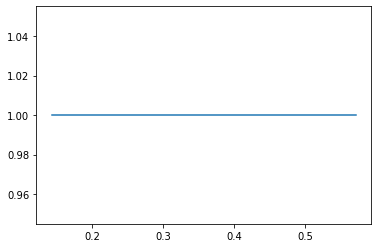

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Recall,Percision)
plt.show()

In [ ]:
interpolation = Percision.copy()
for id,i in enumerate(interpolation):
        array = interpolation[id:len(interpolation)]
        if interpolation[id] < np.max(array):
                interpolation[id] = np.max(array)

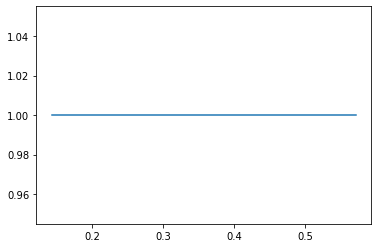

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Recall,interpolation)
plt.show()

In [ ]:
points = set([x for x in interpolation  if interpolation .count(x) > 1])
ap_all = 0
for i in list(points):
  search = np.where(np.array(interpolation) == i)
  indexAll = np.array(search[0]).tolist()
  r2 = Recall[indexAll[len(indexAll)-1]]
  r1 = Recall[indexAll[0]]
  p = interpolation[indexAll[0]]
  ap = (r2-r1)*p
  ap_all = ap_all + ap

In [ ]:
ap_all

0.42857